In [1]:
from PIL import Image
import numpy as np
import os
import pickle
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms

# Use IoU instead
# import re
from scipy.spatial.distance import cdist


# Load image and labels

In [2]:
resize_image_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\image"
resize_label_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\label-rgb"

cityscapes_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\original_cityscapes_inputs"

In [3]:
# get relative path for both datasets, because global path is not allowed ("Not allowed to load local resource")
start = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image"
relative_path_cityscapes = os.path.relpath(cityscapes_path, start)
relative_path_synthia = os.path.relpath(resize_image_path_synthia, start)

save_labels_path_cityscapes = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\cityscapes_labels_100"
save_labels_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\\new_labels_100"

relative_path_cityscapes_labels = os.path.relpath(save_labels_path_cityscapes, start)
relative_path_synthia_labels = os.path.relpath(save_labels_path_synthia, start)

In [4]:
# labels of cityscapes
pickle_file = os.path.join("D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\5_classes_preprocessed", "validation_label_classes.pkl")
with open(pickle_file, 'rb') as f:
    Y_test = pickle.load(f)
    
cityscapes_labels = np.array(Y_test)

In [5]:
# Cityscapes
# import the pickle 
cityscapes_100 = []
cityscapes_image_path_100 = []
cityscapes_label_path_100 = []
cityscapes_labels_100= []

cityscapes_names= os.listdir(cityscapes_path)
random.seed(55)
cityscapes_names_100 = random.sample(cityscapes_names,100)
for name in cityscapes_names_100:
    image = Image.open(cityscapes_path+"\\"+name).convert("RGB")
    cityscapes_100.append(np.array(image))
    cityscapes_image_path_100.append(relative_path_cityscapes+"\\"+name)
    cityscapes_label_path_100.append(relative_path_cityscapes_labels+"\\"+name)
    ind = int(name.split('.')[0])
    label = cityscapes_labels[ind]
    cityscapes_labels_100.append(label)

cityscapes_100 = np.array(cityscapes_100)
cityscapes_image_path_100 = np.array(cityscapes_image_path_100)
cityscapes_label_path_100 = np.array(cityscapes_label_path_100)
cityscapes_labels_100= np.array(cityscapes_labels_100)

# pickle_file = "D:\zsh\graduation\graduation_dataset\\5_classes_preprocessed\\validation_images.pkl"
# with open(pickle_file, 'rb') as f:
#     cityscapes_images = pickle.load(f)
# # randomly select images 100 out of the 500
# cityscapes_100 = random.choices(cityscapes_images, k=100)
# cityscapes_100 = np.array(cityscapes_100)

In [6]:
# synthia

synthia_100 = []
synthia_image_path_100 =[]
synthia_label_path_100 = []
synthia_label_100_initial = []

synthia_names = os.listdir(resize_image_path_synthia)
# randomly select 100 images to load in to numpy array
random.seed(55)
synthia_names_100 = random.sample(synthia_names,100)
for name in synthia_names_100:
#     print(name)
#     print(resize_image_path_synthia)
#     print(resize_image_path_synthia+"\\"+name)
    image = Image.open(resize_image_path_synthia+"\\"+name).convert("RGB")
    
    synthia_100.append(np.array(image))
    synthia_image_path_100.append(relative_path_synthia+"\\"+name)
    synthia_label_path_100.append(relative_path_synthia_labels+"\\"+name)
    label = Image.open(resize_label_path_synthia+"\\"+name).convert("RGB")
    synthia_label_100_initial.append(np.array(label))

synthia_100 = np.array(synthia_100)
synthia_image_path_100 = np.array(synthia_image_path_100)
synthia_label_path_100= np.array(synthia_label_path_100)
synthia_label_100_initial = np.array(synthia_label_100_initial)

# Synthia: Transform label images to classes

In [7]:
synthia_colors = [[  0,   0,   0], # void
         [70,130, 180], # sky
         [70,70,70], # building
        [128, 64, 128], # road
        [244, 35, 232], # sidewalk
         [64,64,128], # fense
         [107,142,35], # vegetation	
        [153, 153, 153], # pole
        [0, 0, 142], # car
        [220, 220, 0],  # traffic sign
        [220, 20, 60], # pedestrian
        [119, 11, 32], # bicycle
        [0, 0, 230], # motorcycle
        [250,170,160], # parking-slot
        [128,64,64], # road-work
        [250,170,30], # traffic light
        [152, 251, 152], # terrain
        [255, 0, 0], # rider
        [0, 0, 70], # truck
        [0, 60, 100], # bus
        [0, 80, 100], # train
        [102, 102, 156]# wall, lanemarking
    ]


category_map = {
    0: 0,
    1: 4,
    2: 0,
    3: 1,
    4: 2,
    5: 0,
    6: 3,
    7: 0,
    8: 5,
    9: 0,
    10: 0,
    11: 0,
    12: 0,
    13: 0,
    14: 0,
    15: 0,
    16: 0,
    17: 0,
    18: 0,
    19: 0,
    20: 0,
    21: 0}

In [8]:
# color to class
def color_to_class(label):
    # create new empty mask
    mask = np.zeros(shape=(label.shape[0], label.shape[1]), dtype = np.int32)
    # iterate through two dimensions
    for row in range(label.shape[0]):
        for col in range(label.shape[1]):
            a = label[row, col,:]
            # distance between this pixel and the original pixel
            d = cdist(np.array([a]),np.array(synthia_colors))
            idx = np.argmin(d)
            new_idx = category_map[idx]
            mask[row, col] = new_idx
    mask = np.reshape(mask, (mask.shape[0], mask.shape[1]))
    return mask

In [9]:
def transform_masks_synthia(labels):
    masks = []
    for label in labels:
        mask = color_to_class(label)
        masks.append(mask)
    masks = np.array(masks)

    return masks

Load the saved labels (alternatively could regenerate labels)

In [10]:
# synthia_label_100_classes = transform_masks_synthia(synthia_label_100_initial)

In [11]:
# save a pickle file to save times for 

# with open('synthia_label_100_classes_new.pkl', 'wb') as file:
      
#     # A new file will be created
#     pickle.dump(synthia_label_100_classes, file)

with open('synthia_label_100_classes_new.pkl', 'rb') as f:
    synthia_label_100_classes = pickle.load(f)


In [12]:
# class to color: useful for displaying the similar images later
colors = [[  0,   0,   0],
          [128, 64, 128],# road
          [244, 35, 232], # sidewalk
          [107, 142, 35],# vegetation
          [70, 130, 180], # sky
          [0, 0, 142], # car
         ]

def class_to_color(labels):
    label_colors = np.zeros((256,256,3))
    
    for i,row in enumerate(labels):
        for j,pixel in enumerate(row):
            label_colors[i,j] = colors[pixel]
    
    return label_colors.astype(int)  # make each pixel value an integer to visualize it better

Generate and save labels for the subset for later

In [15]:
# # # for generating coherent labels for the random subset (cityscapes)
# save_labels_path_cityscapes = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\cityscapes_labels_100"
# for i in range(100):
#     name = cityscapes_names_100[i]
#     label = cityscapes_labels_100[i]
#     label_color = class_to_color(label)
#     label_image = Image.fromarray(label_color.astype(np.uint8))
#     label_image.save(save_labels_path_cityscapes+"\\"+name)

In [16]:
# save_labels_path_synthia = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\SYNTHIA_256\\new_labels_100"
# for i in range(100):
#     name = synthia_names_100[i]
#     label = synthia_label_100_classes[i]
#     label_color = class_to_color(label)
# #     print(label_color.dtype)
# #     print(label_color)
#     label_image = Image.fromarray(label_color.astype(np.uint8))
#     label_image.save(save_labels_path_synthia+"\\"+name)

In [17]:
# start = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image"
# relative_path_cityscapes_labels = os.path.relpath(save_labels_path_cityscapes, start)
# relative_path_synthia_labels = os.path.relpath(save_labels_path_synthia, start)

In [13]:
# find the cityscapes images with mimimal distance to citiscapes images
def most_similar_mask(instance, data,mode = "IoU"):
#     nodes = np.asarray(nodes)
    # Euclidean distance calculation
    if mode == "IoU":
        iou_list = []
        for new_instance in data:
#             the original IoU methods were not good because when both class is 0, the intersection won't count it
#             intersection = np.logical_and(instance, new_instance)
#             union = np.logical_or(instance, new_instance)
            intersection = len(np.where(instance == new_instance)[0])
            union = instance.shape[0]*instance.shape[1]
#             print(intersection)
#             print(union)
            iou_score = intersection / union
            iou_list.append(iou_score)
        iou_arr = np.array(iou_list)
        best_index = np.argmax(iou_arr)
        best_score = iou_arr[best_index]
    
    return best_index, best_score

In [14]:
print(cityscapes_labels_100[0].shape[1])
print(synthia_label_100_classes.shape)

256
(100, 256, 256)


TODO:
make this a dictionary

In [23]:
cityscapes_similar_100_names = []
cityscapes_similar_100_image_paths = [] # relative paths to the cityscapes images
cityscapes_similar_100_labels = []
# cityscapes_similar_100_label_paths = []
cityscapes_similar_100_scores = []

for label in cityscapes_labels_100:
    image_index_synthia,similar_score = most_similar_mask(label,synthia_label_100_classes)
#     print(label.shape)
#     print(synthia_label_100_classes.shape)
#     print(image_index_synthia)
    name = synthia_names_100[image_index_synthia]
    image_path = synthia_image_path_100[image_index_synthia]
#     label_path = relative_path_synthia_labels+"\\"+name
    label = synthia_label_100_classes[image_index_synthia]
    
    cityscapes_similar_100_names.append(name)
    cityscapes_similar_100_image_paths.append(image_path)
    cityscapes_similar_100_labels.append(label)
#     cityscapes_similar_100_label_paths.append(label_path)
    cityscapes_similar_100_scores.append(similar_score)

cityscapes_similar_100_labels= np.array(cityscapes_similar_100_labels)
cityscapes_similar_100_scores = np.array(cityscapes_similar_100_scores)

In [18]:
print(np.where((cityscapes_similar_100_scores>0.6)))

(array([ 2,  6, 13, 18, 21, 24, 29, 33, 36, 38, 40, 41, 43, 47, 50, 51, 57,
       61, 65, 66, 67, 68, 74, 77, 83, 92, 95, 97, 99], dtype=int64),)


In [24]:
# synthia_similar_100_names = []
# synthia_similar_100_paths = [] # relative paths to the synthia images
# for label in synthia_label_100_classes:
#     image_index_cityscapes = most_similar_mask(label,cityscapes_labels_100)
#     name = cityscapes_names_100[image_index_cityscapes]
#     path = cityscapes_path_100[image_index_cityscapes]
#     synthia_similar_100_names.append(name)
#     synthia_similar_100_paths.append(path)

synthia_similar_100_names = []
synthia_similar_100_image_paths = [] # relative paths to the cityscapes images
synthia_similar_100_labels = []
# synthia_similar_100_label_paths = []
synthia_similar_100_scores = []

for label in synthia_label_100_classes:
    image_index_cityscapes,similar_score = most_similar_mask(label,cityscapes_labels_100)
    name = cityscapes_names_100[image_index_cityscapes]
    image_path = cityscapes_image_path_100[image_index_cityscapes]
    label = cityscapes_labels_100[image_index_cityscapes]
    label_path = relative_path_cityscapes_labels+"\\"+name
    synthia_similar_100_names.append(name)
    synthia_similar_100_image_paths.append(image_path)
    synthia_similar_100_labels.append(label)
#     synthia_similar_100_label_paths.append(label_path)
    synthia_similar_100_scores.append(similar_score)

synthia_similar_100_labels= np.array(synthia_similar_100_labels)
synthia_similar_100_scores = np.array(synthia_similar_100_scores)

[43 50 51 57 68 74 99]
0.8092041015625
0.7506866455078125
0.807220458984375
0.809783935546875
0.7834014892578125
0.7004241943359375


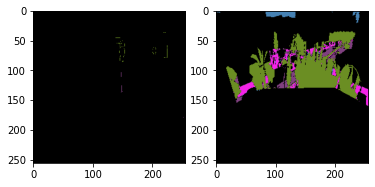

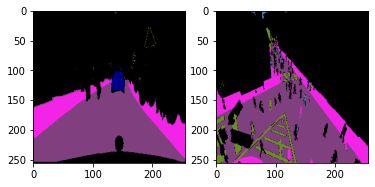

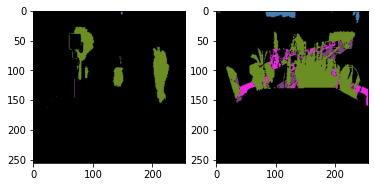

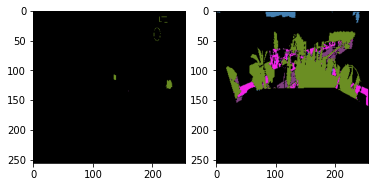

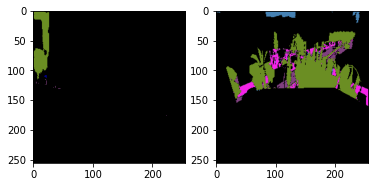

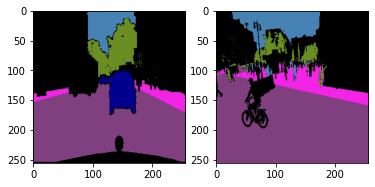

In [25]:
threshold = 0.65
indices = np.where((cityscapes_similar_100_scores>0.7))[0]
print(indices)
count = 0
for i in indices:
    cityscapes_similar_100_labels[i].shape
    synthia_label = class_to_color(cityscapes_similar_100_labels[i])
    cityscapes_label = class_to_color(cityscapes_labels_100[i])
    print(cityscapes_similar_100_scores[i])

    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(cityscapes_label)
    ax2.imshow(synthia_label)
    count +=1
    if count>5: 
        break

# Embedding for the input （pca and tsne）

In [37]:
num_images = 100

In [38]:
# concatenate the images and the paths from two different dataset
combined_embedding = np.concatenate((cityscapes_100,synthia_100),axis=0)
combined_embedding = np.reshape(combined_embedding,(len(combined_embedding), 256*256*3))

combined_image_paths = np.concatenate((cityscapes_image_path_100,synthia_image_path_100),axis=0)
combined_label_paths = np.concatenate((cityscapes_label_path_100,synthia_label_path_100),axis=0)
combined_names = np.concatenate((cityscapes_names_100,synthia_names_100),axis=0)

In [39]:
pca = PCA(n_components=2)
pca_embedding = pca.fit_transform(combined_embedding)
# print(pca.explained_variance_ratio_)

df_pca = pd.DataFrame(pca_embedding,columns=["pca_1","pca_2"])

In [40]:
pca_50 = PCA(n_components=50)
pca_embedding = pca_50.fit_transform(combined_embedding)
print(np.sum(pca_50.explained_variance_ratio_))
tsne = TSNE()
tsne_embedding = tsne.fit_transform(pca_embedding)

df_tsne = pd.DataFrame(tsne_embedding,columns=["tsne_1","tsne_2"])
df_tsne.head()

0.7973082197415827


,tsne_1,tsne_2
0,-1.529361,4.458914
1,3.349173,0.296529
2,-5.709057,0.009456
3,-1.396583,-0.194321
4,-3.185254,4.316854


In [41]:
df = pd.concat([df_pca, df_tsne], axis=1)
df["dataset"] =np.nan
df["name"] = combined_names
df["image_path"] = combined_image_paths
df["label_path"] = combined_label_paths

# mark the dataset name
df["dataset"].iloc[:num_images] = "Cityscapes"
df["dataset"].iloc[num_images:] = "Synthia"

d:\zsh\graduation\grad_env_take_2\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [42]:
df_cityscapes = df.iloc[:num_images,:]
df_synthia = df.iloc[num_images:,:]

In [43]:
synthia_similar_100_labels.shape

(100, 256, 256)

In [44]:
# df_synthia["similar_name"] = synthia_similar_100_names
df_synthia["similar_image_paths"] =synthia_similar_100_image_paths
# df_synthia["similar_label_paths"] = synthia_similar_100_label_paths
df_synthia["IoU_score"]=synthia_similar_100_scores

d:\zsh\graduation\grad_env_take_2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\zsh\graduation\grad_env_take_2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [45]:
df_synthia.head()

,pca_1,pca_2,tsne_1,tsne_2,dataset,name,image_path,label_path,similar_image_paths,IoU_score
100,-16323.851322,-2716.314956,4.688591,-5.439641,Synthia,0001480.png,dataset\SYNTHIA_256\image\0001480.png,dataset\SYNTHIA_256\new_labels_100\0001480.png,dataset\original_cityscapes_inputs\237.jpeg,0.435898
101,-19717.417386,359.187552,6.011597,-6.535163,Synthia,0003215.png,dataset\SYNTHIA_256\image\0003215.png,dataset\SYNTHIA_256\new_labels_100\0003215.png,dataset\original_cityscapes_inputs\188.jpeg,0.492340
102,-17868.910769,1337.739410,5.724001,-6.727709,Synthia,0002457.png,dataset\SYNTHIA_256\image\0002457.png,dataset\SYNTHIA_256\new_labels_100\0002457.png,dataset\original_cityscapes_inputs\147.jpeg,0.487686
103,-15686.410723,-5517.977015,4.406576,-5.382485,Synthia,0004959.png,dataset\SYNTHIA_256\image\0004959.png,dataset\SYNTHIA_256\new_labels_100\0004959.png,dataset\original_cityscapes_inputs\101.jpeg,0.587204
104,-5020.711841,19910.826054,6.920467,-1.219972,Synthia,0001305.png,dataset\SYNTHIA_256\image\0001305.png,dataset\SYNTHIA_256\new_labels_100\0001305.png,dataset\original_cityscapes_inputs\423.jpeg,0.536331


In [46]:
# df_cityscapes["similar_name"] = cityscapes_similar_100_names
df_cityscapes["similar_image_paths"] =cityscapes_similar_100_image_paths
# df_cityscapes["similar_label_paths"] = cityscapes_similar_100_label_paths
df_cityscapes["IoU_score"]=cityscapes_similar_100_scores

d:\zsh\graduation\grad_env_take_2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
d:\zsh\graduation\grad_env_take_2\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [47]:
df_cityscapes.head()

,pca_1,pca_2,tsne_1,tsne_2,dataset,name,image_path,label_path,similar_image_paths,IoU_score
0,2625.505743,-6238.133702,-1.529361,4.458914,Cityscapes,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,dataset\cityscapes_labels_100\14.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.475754
1,3934.173840,1301.541900,3.349173,0.296529,Cityscapes,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,dataset\cityscapes_labels_100\87.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.480301
2,5246.379126,-149.925451,-5.709057,0.009456,Cityscapes,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,dataset\cityscapes_labels_100\189.jpeg,dataset\SYNTHIA_256\image\0004607.png,0.653656
3,-2283.366500,-635.567539,-1.396583,-0.194321,Cityscapes,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,dataset\cityscapes_labels_100\167.jpeg,dataset\SYNTHIA_256\image\0005291.png,0.453262
4,2057.622065,-11766.691214,-3.185254,4.316854,Cityscapes,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,dataset\cityscapes_labels_100\439.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.522873


In [48]:
df = pd.concat([df_cityscapes, df_synthia], axis=0)

In [49]:
df.head()

,pca_1,pca_2,tsne_1,tsne_2,dataset,name,image_path,label_path,similar_image_paths,IoU_score
0,2625.505743,-6238.133702,-1.529361,4.458914,Cityscapes,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,dataset\cityscapes_labels_100\14.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.475754
1,3934.173840,1301.541900,3.349173,0.296529,Cityscapes,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,dataset\cityscapes_labels_100\87.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.480301
2,5246.379126,-149.925451,-5.709057,0.009456,Cityscapes,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,dataset\cityscapes_labels_100\189.jpeg,dataset\SYNTHIA_256\image\0004607.png,0.653656
3,-2283.366500,-635.567539,-1.396583,-0.194321,Cityscapes,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,dataset\cityscapes_labels_100\167.jpeg,dataset\SYNTHIA_256\image\0005291.png,0.453262
4,2057.622065,-11766.691214,-3.185254,4.316854,Cityscapes,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,dataset\cityscapes_labels_100\439.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.522873


In [50]:
df.iloc[100:105]

,pca_1,pca_2,tsne_1,tsne_2,dataset,name,image_path,label_path,similar_image_paths,IoU_score
100,-16323.851322,-2716.314956,4.688591,-5.439641,Synthia,0001480.png,dataset\SYNTHIA_256\image\0001480.png,dataset\SYNTHIA_256\new_labels_100\0001480.png,dataset\original_cityscapes_inputs\237.jpeg,0.435898
101,-19717.417386,359.187552,6.011597,-6.535163,Synthia,0003215.png,dataset\SYNTHIA_256\image\0003215.png,dataset\SYNTHIA_256\new_labels_100\0003215.png,dataset\original_cityscapes_inputs\188.jpeg,0.492340
102,-17868.910769,1337.739410,5.724001,-6.727709,Synthia,0002457.png,dataset\SYNTHIA_256\image\0002457.png,dataset\SYNTHIA_256\new_labels_100\0002457.png,dataset\original_cityscapes_inputs\147.jpeg,0.487686
103,-15686.410723,-5517.977015,4.406576,-5.382485,Synthia,0004959.png,dataset\SYNTHIA_256\image\0004959.png,dataset\SYNTHIA_256\new_labels_100\0004959.png,dataset\original_cityscapes_inputs\101.jpeg,0.587204
104,-5020.711841,19910.826054,6.920467,-1.219972,Synthia,0001305.png,dataset\SYNTHIA_256\image\0001305.png,dataset\SYNTHIA_256\new_labels_100\0001305.png,dataset\original_cityscapes_inputs\423.jpeg,0.536331


<AxesSubplot:xlabel='tsne_1', ylabel='tsne_2'>

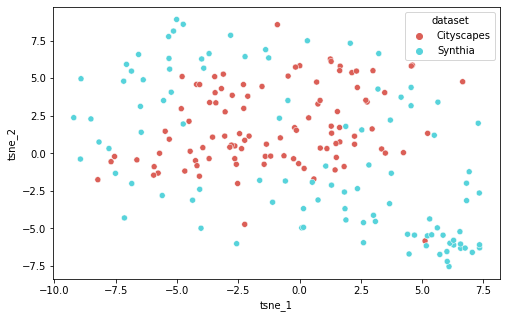

In [51]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne_1", y="tsne_2",
    hue="dataset", # see if this need to be changed
    palette=sns.color_palette("hls", 2), # palette corresponds to hue
    data=df # df_tsne_1 or df_tsne_2
)

In [56]:
df.to_csv("input_df_similarity_v4.csv",index=False)

# Link to model activations

**If start from here: load the csv file into a dataframe**

In [58]:
df = pd.read_csv('input_df_similarity_v4.csv')

In [41]:
# load the model

How do you save the activations? A separate file or together with this dataframe?

In [59]:
df.head()

,pca_1,pca_2,tsne_1,tsne_2,dataset,name,image_path,label_path,similar_image_paths,IoU_score
0,2625.505743,-6238.133702,-1.529361,4.458914,Cityscapes,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,dataset\cityscapes_labels_100\14.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.475754
1,3934.173840,1301.541900,3.349173,0.296529,Cityscapes,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,dataset\cityscapes_labels_100\87.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.480301
2,5246.379126,-149.925451,-5.709057,0.009456,Cityscapes,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,dataset\cityscapes_labels_100\189.jpeg,dataset\SYNTHIA_256\image\0004607.png,0.653656
3,-2283.366500,-635.567539,-1.396583,-0.194321,Cityscapes,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,dataset\cityscapes_labels_100\167.jpeg,dataset\SYNTHIA_256\image\0005291.png,0.453262
4,2057.622065,-11766.691214,-3.185254,4.316854,Cityscapes,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,dataset\cityscapes_labels_100\439.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.522873


# Load model and data

In [60]:
# check the input size for the Cityscapes Dataset by loading X_test, Y_test
data_pth = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\dataset\\5_classes_preprocessed"

pickle_file = os.path.join(data_pth, "validation_images.pkl")
with open(pickle_file, 'rb') as f:
    X_test = pickle.load(f)
    
pickle_file = os.path.join(data_pth, "validation_label_classes.pkl")
with open(pickle_file, 'rb') as f:
    Y_test = pickle.load(f)

In [61]:
with open('synthia_label_100_classes.pkl', 'rb') as f:
    synthia_label_100_classes = pickle.load(f)

In [62]:
print(np.array(X_test).shape)
print(np.array(Y_test).shape)
print(synthia_label_100_classes.shape)

(500, 256, 256, 3)
(500, 256, 256)
(150, 256, 256)


In [63]:
class CityscapesDataset(Dataset):
    
    def __init__(self, images, labels, noise_level = 0):
        self.images = images
        self.labels = labels
        self.noise_level = noise_level
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        image = self.images[index]
        label = self.labels[index]
        if self.noise_level!=0:
            image = image+(self.noise_level*np.random.normal(0, (image.max() - image.min()), image.shape)).astype("uint8") # (mean, sigma, image_shape)
        image = self.transform(image)
        label = torch.from_numpy(label).long()
        return image, label
        
    def transform(self, image):
        transform_ops = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)) # normalize to control the "dynamic range" of activations of different layers
        ])
        return transform_ops(image)

In [64]:
repo_path = "D:\zsh\graduation\\Graduation-project-domain-shift-image-2-image"
# cityscapes_label_path = "dataset\\cityscapes_labels_100"
cityscapes_images = []
cityscapes_labels = []
synthia_images = []
synthia_labels = []

for index,path in enumerate(df["image_path"]):
    full_path = os.path.join(repo_path,path)
    dataset = df["dataset"].iloc[index]
    # parse to get the name of image
    name = os.path.split(path)[1]
    label_index = int(name.split(".")[0])
    if dataset == "Cityscapes":
        # image
        img = Image.open(full_path)
        img = np.array(img)
        # label
        label = Y_test[label_index]
        label = np.array(label)
        cityscapes_images.append(img)
        cityscapes_labels.append(label)
    elif dataset == "Synthia":
        # image
        img = Image.open(full_path)
        img = np.array(img)
        # label
        label = synthia_label_100_classes[index-100]
        label = np.array(label)
        synthia_images.append(img)
        synthia_labels.append(label)
    

In [66]:
cityscapes_images = np.array(cityscapes_images)
cityscapes_labels = np.array(cityscapes_labels)
synthia_images = np.array(synthia_images)
synthia_labels = np.array(synthia_labels)

print(synthia_images.shape)
print(synthia_images.shape)

# load to Dataset class and DataLoader
batch_size = 1
cityscapes_dataset = CityscapesDataset(cityscapes_images, cityscapes_labels,noise_level=0)
cityscapes_loader = DataLoader(cityscapes_dataset, batch_size=batch_size)

synthia_dataset = CityscapesDataset(synthia_images, synthia_labels,noise_level=0)
synthia_loader = DataLoader(synthia_dataset, batch_size=batch_size)

(100, 256, 256, 3)
(100, 256, 256, 3)


Load the UNet model

In [67]:
class UNet(nn.Module):
    
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.num_classes = num_classes
        self.contracting_11 = self.conv_block(in_channels=3, out_channels=64)
        self.contracting_12 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_21 = self.conv_block(in_channels=64, out_channels=128)
        self.contracting_22 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_31 = self.conv_block(in_channels=128, out_channels=256)
        self.contracting_32 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.contracting_41 = self.conv_block(in_channels=256, out_channels=512)
        self.contracting_42 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.middle = self.conv_block(in_channels=512, out_channels=1024)
        self.expansive_11 = nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_12 = self.conv_block(in_channels=1024, out_channels=512)
        self.expansive_21 = nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_22 = self.conv_block(in_channels=512, out_channels=256)
        self.expansive_31 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_32 = self.conv_block(in_channels=256, out_channels=128)
        self.expansive_41 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.expansive_42 = self.conv_block(in_channels=128, out_channels=64)
        self.output = nn.Conv2d(in_channels=64, out_channels=num_classes, kernel_size=3, stride=1, padding=1)
        
    def conv_block(self, in_channels, out_channels):
        block = nn.Sequential(nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels),
                                    nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
                                    nn.ReLU(),
                                    nn.BatchNorm2d(num_features=out_channels))
        return block
    
    def forward(self, X):
        contracting_11_out = self.contracting_11(X) # [-1, 64, 256, 256]
        contracting_12_out = self.contracting_12(contracting_11_out) # [-1, 64, 128, 128]
        contracting_21_out = self.contracting_21(contracting_12_out) # [-1, 128, 128, 128]
        contracting_22_out = self.contracting_22(contracting_21_out) # [-1, 128, 64, 64]
        contracting_31_out = self.contracting_31(contracting_22_out) # [-1, 256, 64, 64]
        contracting_32_out = self.contracting_32(contracting_31_out) # [-1, 256, 32, 32]
        contracting_41_out = self.contracting_41(contracting_32_out) # [-1, 512, 32, 32]
        contracting_42_out = self.contracting_42(contracting_41_out) # [-1, 512, 16, 16]
        middle_out = self.middle(contracting_42_out) # [-1, 1024, 16, 16]
        expansive_11_out = self.expansive_11(middle_out) # [-1, 512, 32, 32]
        expansive_12_out = self.expansive_12(torch.cat((expansive_11_out, contracting_41_out), dim=1)) # [-1, 1024, 32, 32] -> [-1, 512, 32, 32]
        expansive_21_out = self.expansive_21(expansive_12_out) # [-1, 256, 64, 64]
        expansive_22_out = self.expansive_22(torch.cat((expansive_21_out, contracting_31_out), dim=1)) # [-1, 512, 64, 64] -> [-1, 256, 64, 64]
        expansive_31_out = self.expansive_31(expansive_22_out) # [-1, 128, 128, 128]
        expansive_32_out = self.expansive_32(torch.cat((expansive_31_out, contracting_21_out), dim=1)) # [-1, 256, 128, 128] -> [-1, 128, 128, 128]
        expansive_41_out = self.expansive_41(expansive_32_out) # [-1, 64, 256, 256]
        expansive_42_out = self.expansive_42(torch.cat((expansive_41_out, contracting_11_out), dim=1)) # [-1, 128, 256, 256] -> [-1, 64, 256, 256]
        output_out = self.output(expansive_42_out) # [-1, num_classes, 256, 256]
        return output_out

In [68]:
model_path = "D:\zsh\graduation\Graduation-project-domain-shift-image-2-image\models\\5-classes-U-Net-2023-03-09.pth"

device = torch.device('cpu')
model_ = UNet(num_classes=6).to(device)
model_.load_state_dict(torch.load(model_path,map_location=device))

<All keys matched successfully>

In [51]:
def getActivation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

cityscapes_activations = []
for image,label in cityscapes_loader:
    activation = {}
    h = model_.middle[3].register_forward_hook(getActivation("bottleneck"))
    out = model_(image)
    h.remove()
    instance_activation = activation["bottleneck"]
#     print(instance_activation.size())
    # need to reshape
    instance_activation_reshaped = instance_activation.clone().squeeze(0).reshape(256,1024).numpy()
    cityscapes_activations.append(instance_activation_reshaped)
#     print(instance_activation_reshaped.shape)

In [52]:
synthia_activations = []
for image,label in synthia_loader:
    activation = {}
    h = model_.middle[3].register_forward_hook(getActivation("bottleneck"))
    out = model_(image)
    h.remove()
    instance_activation = activation["bottleneck"]
#     print(instance_activation.size())
    # need to reshape
    instance_activation_reshaped = instance_activation.clone().squeeze(0).reshape(256,1024).numpy()
    synthia_activations.append(instance_activation_reshaped)

In [53]:
cityscapes_activations = np.array(cityscapes_activations)
cityscapes_activations.shape

(100, 256, 1024)

In [54]:
synthia_activations = np.array(synthia_activations)
synthia_activations.shape

(100, 256, 1024)

In [55]:
with open('cityscapes_activations.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(cityscapes_activations, file)

with open('synthia_activations.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(synthia_activations, file)

In [69]:
with open("cityscapes_activations.pkl", 'rb') as f:
    cityscapes_activations = pickle.load(f)
    
with open("synthia_activations.pkl", 'rb') as f:
    synthia_activations = pickle.load(f)

In [70]:
combined_activations = np.concatenate([cityscapes_activations,synthia_activations],axis =0)

In [71]:
combined_activations.shape

(200, 256, 1024)

In [72]:
len(df)

200

# Dimensionality reduction

Generate embedding before putting it into df

In [73]:
# function for reducing the dimensionality of an image
def instance_dimenisonality_reduction(data, mode = "pca_tsne"):
    # this part might need to be moved to the outside
    # first reduce the dimension from 1024 to 50 with PCA
    if mode == "pca":
        pca = PCA(n_components=2)
        embedded = pca.fit_transform(data)
        print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
    elif mode == "tsne":
        embedded = TSNE(n_components=2).fit_transform(data)
    elif mode == "pca_tsne":
        pca = PCA(n_components=30)
        pca_embedding = pca.fit_transform(data)
        embedded = TSNE(n_components=2).fit_transform(pca_embedding)
#         print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
#         print(np.cumsum(pca.explained_variance_ratio_))
    else:
        print("Need to specify mode: pca or tsne")
        return 0
    
    return embedded

In [74]:
embeddings = []
for instance in combined_activations:
    embedding = instance_dimenisonality_reduction(instance)
    embeddings.append(embedding)

embeddings = np.array(embeddings)

KeyboardInterrupt: 

In [74]:
# save the embeddings for future use
with open('activations_embeddings.pkl', 'wb') as file:
      
    # A new file will be created
    pickle.dump(embeddings, file)

In [75]:
with open("activations_embeddings.pkl", 'rb') as f:
    embeddings = pickle.load(f)

In [75]:
combined_activations.shape

(200, 256, 1024)

In [76]:
df["bottleneck_activations_embedding"] = embeddings.tolist()

In [77]:
df.head()

,pca_1,pca_2,tsne_1,tsne_2,dataset,name,image_path,label_path,similar_image_paths,IoU_score,bottleneck_activations_embedding
0,2625.505743,-6238.133702,-1.529361,4.458914,Cityscapes,14.jpeg,dataset\original_cityscapes_inputs\14.jpeg,dataset\cityscapes_labels_100\14.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.475754,"[[1.8898383378982544, 1.1155751943588257], [-5..."
1,3934.173840,1301.541900,3.349173,0.296529,Cityscapes,87.jpeg,dataset\original_cityscapes_inputs\87.jpeg,dataset\cityscapes_labels_100\87.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.480301,"[[0.19028380513191223, 2.180586814880371], [7...."
2,5246.379126,-149.925451,-5.709057,0.009456,Cityscapes,189.jpeg,dataset\original_cityscapes_inputs\189.jpeg,dataset\cityscapes_labels_100\189.jpeg,dataset\SYNTHIA_256\image\0004607.png,0.653656,"[[-11.183615684509277, -3.835369110107422], [-..."
3,-2283.366500,-635.567539,-1.396583,-0.194321,Cityscapes,167.jpeg,dataset\original_cityscapes_inputs\167.jpeg,dataset\cityscapes_labels_100\167.jpeg,dataset\SYNTHIA_256\image\0005291.png,0.453262,"[[-3.408116102218628, -6.009547710418701], [-5..."
4,2057.622065,-11766.691214,-3.185254,4.316854,Cityscapes,439.jpeg,dataset\original_cityscapes_inputs\439.jpeg,dataset\cityscapes_labels_100\439.jpeg,dataset\SYNTHIA_256\image\0002688.png,0.522873,"[[-0.2733990252017975, -5.647787094116211], [-..."


In [79]:
df.to_csv("df_linked_v2.csv",index=False)

In [83]:
embeddings

array([[[  1.8898383 ,   1.1155752 ],
        [ -5.0258646 ,  -2.5032105 ],
        [ -5.012864  ,   7.722998  ],
        ...,
        [ -6.6282363 ,  -3.7369747 ],
        [  6.69353   ,  -8.197266  ],
        [ 13.603943  ,  -0.26343578]],

       [[  0.1902838 ,   2.1805868 ],
        [  7.837532  ,  -1.5901432 ],
        [ -1.2136091 ,  -1.875444  ],
        ...,
        [ 16.438566  ,  -4.5652833 ],
        [ -5.695369  ,  -4.6528883 ],
        [ -6.8936667 ,  13.268232  ]],

       [[-11.183616  ,  -3.835369  ],
        [ -1.7804009 ,   1.2482502 ],
        [ -4.8562856 ,  13.35659   ],
        ...,
        [  3.1348999 ,  -0.67187697],
        [ 18.306137  ,  -7.8755465 ],
        [-12.724665  , -17.52808   ]],

       ...,

       [[-10.850699  ,  -1.5585119 ],
        [ -3.7833648 ,  -8.068903  ],
        [  1.1235105 ,   4.5092797 ],
        ...,
        [ -1.0383126 ,  -6.5747423 ],
        [ -8.392109  ,  10.888018  ],
        [-12.007097  ,   9.036607  ]],

       [[  8.41

In [ ]:
200* 256*2